## Supervised Learning Final Project: Modelling Insurance Costs

**The problem**: A fictional insurance company, Mass Insurance, needs a way to calculate what they should charge their clients based on client-specific factors (e.g. is the client a smoker?)

**The solution**: We will train and refine a multivariate OLS (ordinary least squares) regression model for this exact purpose, such that Mass Insurance can input determining factors into the model and the model will return the amount that they should charge their new client.

### The data
Our data is a public dataset that was sourced from Kaggle (see citation below) and downloaded as a CSV. It consists of over a thousand records that represent insured individuals, including what their (presumably annual) insurance charges are and as well as various health factors, such as if the individual is a smoker, their age, etc.

*APA Citation*: Jain, Simran. (2020). Insurance Premium Data. [Data set]. Kaggle. https://www.kaggle.com/datasets/simranjain17/insurance

 <u>**Data breakdown**</u> 
 
 **Number of records**: 1338
 
 **Number of columns**: 7
 
 **Dependent variable**
- **Charges**: *float* - The amount that the insured pays for insurance (presumably annual)
        
 **Independent variables**
- **Age**: *integer* - The age of the insured
- **Sex**: *category (male, female)* - The sex of the insured
- **BMI**: *integer* - The BMI (body mass index) of the insured
- **Children**: *integer* - The number of children of the insured
- **Smoker**: *category (yes, no)* - Whether the insured is a smoker
- **Region**: *category (southwest, southeast, northwest, northeast)* - The region where the insured lives
        

In [90]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import sklearn.model_selection
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('insurance.csv')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


**Data cleaning pt 1**

This is redundant...

In [91]:
# drop NaN rows (CSV has at least one empty row)
data = data.dropna(how='any')

**Data cleaning pt 1.5**

Checking for outliers, make sure distribution looks correct.

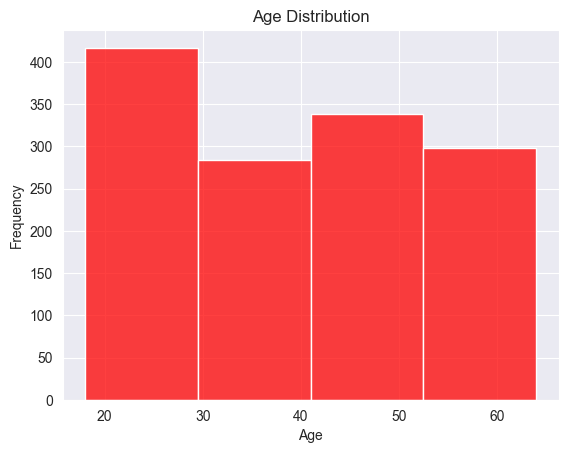

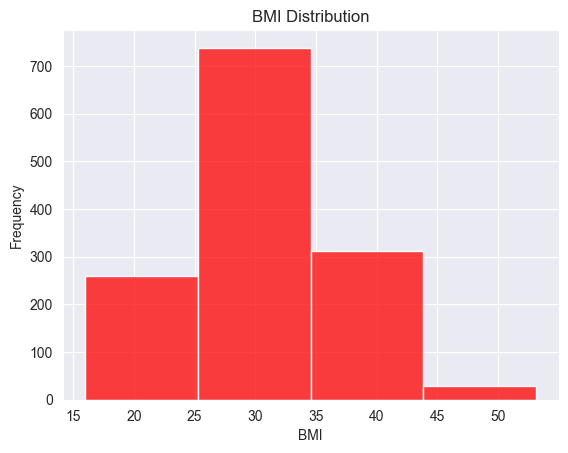

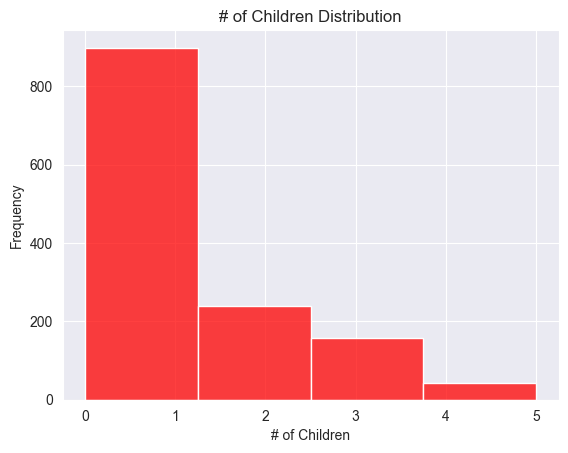

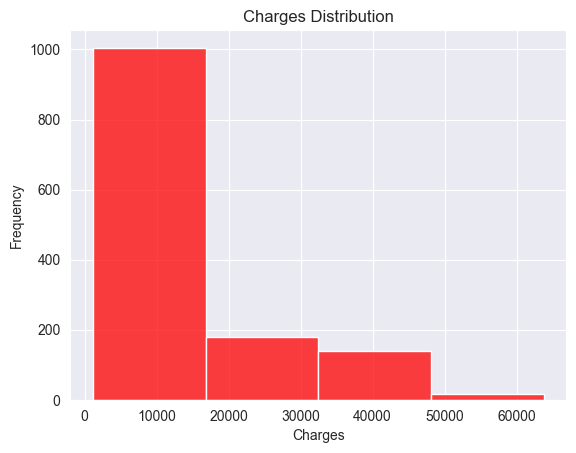

In [92]:
sns.histplot(data['age'], bins=4, kde=False, color='red')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['bmi'], bins=4, kde=False, color='red')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['children'], bins=4, kde=False, color='red')
plt.title('# of Children Distribution')
plt.xlabel('# of Children')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['charges'], bins=4, kde=False, color='red')
plt.title('Charges Distribution')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

**Data cleaning conclusions**

Really, this dataset is already very clean.

**Initial EDA**

Age and BMI have some correlation, but not a ton.

Axes(0.125,0.11;0.62x0.77)


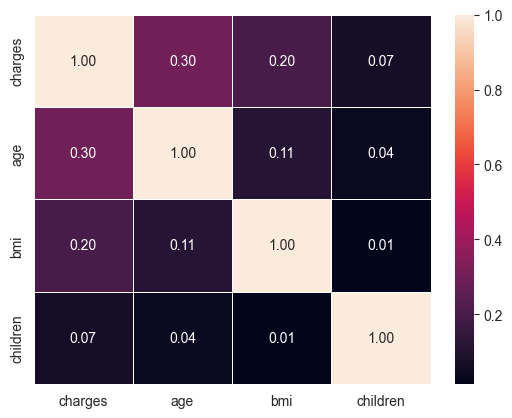

In [93]:
cols = ['charges'] + [col for col in data if col != 'charges']
data = data[cols]

prelim_eda_data = data.select_dtypes(include=['int64', 'float64'])


corr = prelim_eda_data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: feature engineering pt 1**
 
We have some categorical features that need to be encoded properly if they are to be used in our regression model.

The first, and easiest to encode is the feature that describes whether the insured is a smoker.

In [94]:
# convert smoker to binary
smoker_map = {'yes': 1, 'no': 0}
data['smoker'] = data['smoker'].apply(lambda x: smoker_map[x])

**Models: feature engineering pt 2**

Next, we have a couple of categorical features (`sex` and `region`) which are slightly harder to encode as they are not ordinal categorical variables and
thus cannot be encoded into integers.

However, we can easily one-hot encode both of these features using the pandas `get_dummies` method.


In [95]:
# one-hot encoding for categorical variables
data = pd.get_dummies(data, columns=['sex', 'region'], dtype='int')

# looking at data, all features can be analyzed now
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   charges           1338 non-null   float64
 1   age               1338 non-null   int64  
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   int64  
 5   sex_female        1338 non-null   int64  
 6   sex_male          1338 non-null   int64  
 7   region_northeast  1338 non-null   int64  
 8   region_northwest  1338 non-null   int64  
 9   region_southeast  1338 non-null   int64  
 10  region_southwest  1338 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 115.1 KB
None


**EDA revisited**

Next, we do some revisited EDA with our new encoded features.

Axes(0.125,0.11;0.62x0.77)


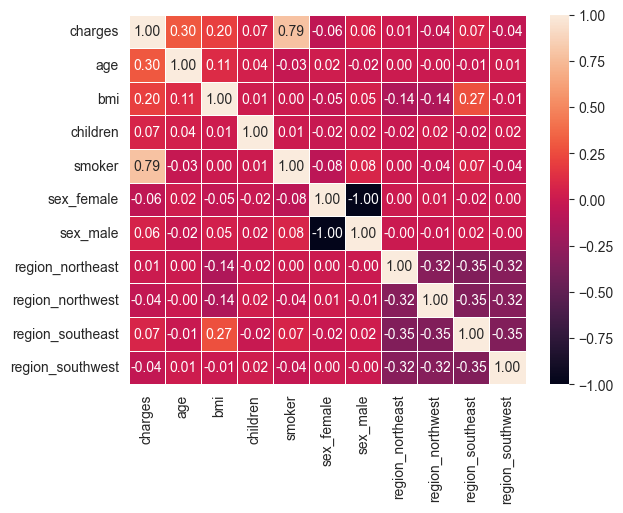

In [96]:

corr = data.corr(method='pearson')

heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)

print(heatmap)

**Models: feature engineering pt 3**

As you can see, previously we used one-hot encoding to convert our categorical features.

For our feature selection, we are going to drop all features except for `smoker`, `age`, and `bmi` since these were the features with the highest correlation with `charges`.

In [97]:
data = data[['charges', 'smoker', 'age', 'bmi']]

**Models: multi-linear regression/collinearity**

Now that our top three features are selected, we can see that these features do not display collinearity as each feature's correlation with each other is quite low, as is evidenced by our simplified correlation heatmap.


Axes(0.125,0.11;0.62x0.77)


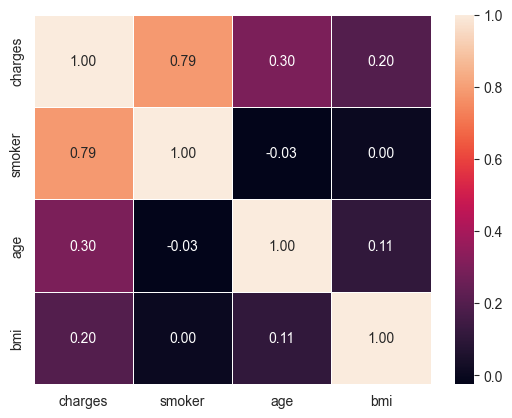

In [98]:
corr = data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: the models themselves pt 1**

First, we'll test a simple uni-variate linear regression model, using `smoker` as our sole independent variable.



In [99]:
X_train, X_test = sklearn.model_selection.train_test_split(data, test_size=0.2)

# todo interaction terms?
uni_model = smf.ols(formula='charges ~ smoker', data=X_train).fit()
print(uni_model.summary())
adj_R2 = uni_model.rsquared
print(adj_R2)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1725.
Date:                Fri, 24 May 2024   Prob (F-statistic):          3.37e-225
Time:                        07:03:46   Log-Likelihood:                -11061.
No. Observations:                1070   AIC:                         2.213e+04
Df Residuals:                    1068   BIC:                         2.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8404.6859    255.721     32.867      0.0

**Models: the models themselves pt 2**

To improve our r-squared, we'll introduce two more independent variables to create a multivariate, or multilinear regression model that has a higher r-squared value.


In [100]:



multi_model = smf.ols(formula='charges ~ smoker + age + bmi', data=X_train).fit()
multi_r2 = multi_model.rsquared

# todo p-value analysis
print(multi_model.summary())
print(multi_r2)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1062.
Date:                Fri, 24 May 2024   Prob (F-statistic):          1.27e-319
Time:                        07:03:46   Log-Likelihood:                -10835.
No. Observations:                1070   AIC:                         2.168e+04
Df Residuals:                    1066   BIC:                         2.170e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.192e+04   1036.764    -11.494      0.0

**Results analysis**

Here, we analyze our results from each model - first, the univariate.

MSE 55382945.45298104
R2 0.6274695707593361
MAE 5709.4370219008315
Mean charges: 13687.739405447763


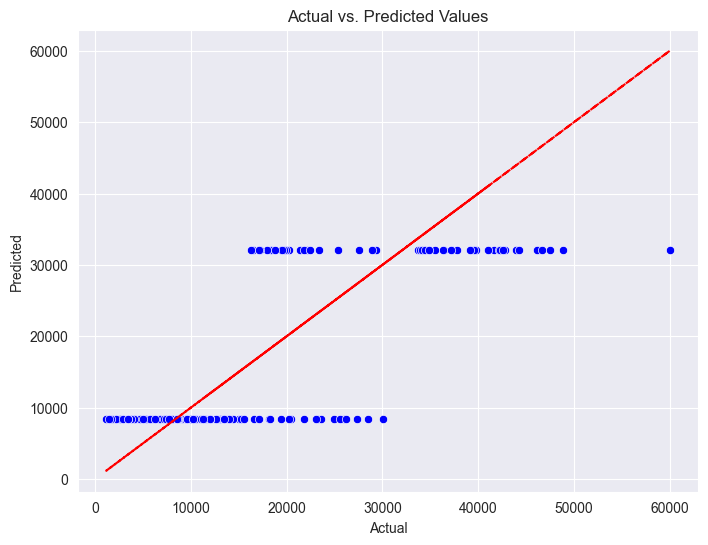

In [101]:

from sklearn.metrics import mean_squared_error, r2_score

y_pred = uni_model.predict(X_test)
y_test = X_test['charges']

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE {mse}')
print(f'R2 {r2}')
print(f'MAE {mae}')

mean_charges = sum(y_test) / len(y_test)
print(f'Mean charges: {mean_charges}')

# results plot
data = pd.DataFrame({    'Actual': y_test,    'Predicted': y_pred})
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, marker='o', color='blue')
plt.plot(data['Actual'], data['Actual'], 'r--')  # Red dashed line for perfect prediction
plt.title('Actual vs. Predicted Values')
plt.show()





Next, the multivariate...

MSE 38675712.8985581
R2 0.7398498796074232
MAE 4462.415985328398
Mean charges: 13687.739405447763


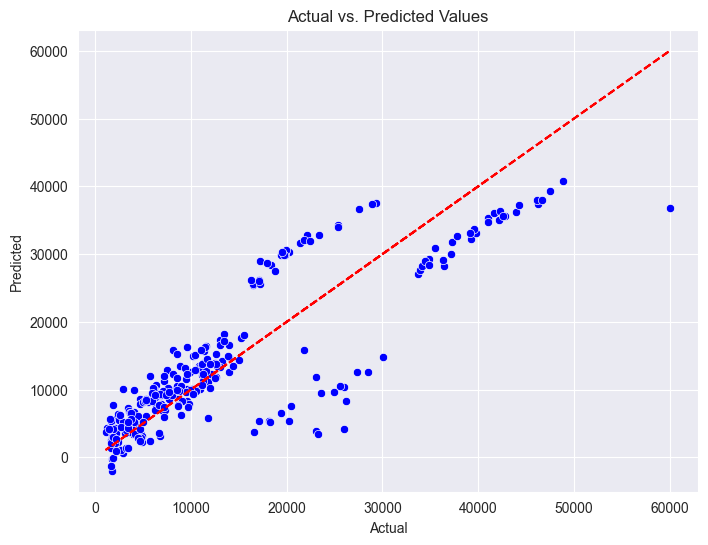

In [102]:

from sklearn.metrics import mean_squared_error, r2_score

y_pred = multi_model.predict(X_test)
y_test = X_test['charges']

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE {mse}')
print(f'R2 {r2}')
print(f'MAE {mae}')

mean_charges = sum(y_test) / len(y_test)
print(f'Mean charges: {mean_charges}')

# results plot
data = pd.DataFrame({    'Actual': y_test,    'Predicted': y_pred})
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, marker='o', color='blue')
plt.plot(data['Actual'], data['Actual'], 'r--')  # Red dashed line for perfect prediction
plt.title('Actual vs. Predicted Values')
plt.show()



